# Smooth sailing

In [18]:
from matplotlib import animation, patches
from IPython.display import display_html
import matplotlib.pyplot as plt
from itertools import product
from math import sin, cos
from tqdm import tqdm
import pandas as pd
import numpy as np
from z3 import *

pd.options.display.float_format = '{:,.2f}'.format
%config InlineBackend.figure_format = "svg"
%matplotlib inline

### Constantes globais

In [3]:
V_LOW, V_HIGH = 1, 10 # velocidades dos modos baixo e alto, em m
THETA = 15 # angulo de viragem entre modos
TAU = 3 # tempo minimo entre transicoes timed
ALL_ROUTES = [i*THETA for i in range(int(360/THETA))] # todos os ângulos possíveis
ALL_VELS = [V_LOW, V_HIGH] # todas as velocidades possiveis

GAUSS_DP = 150 # desvio padrão da gaussiana de inicialização das posições em m
SAFE_DIST = 100 # distância de segurança entre barcos em m

Mode, (M_LOW, M_HIGH) = EnumSort("Mode", ("V_LOW", "V_HIGH"))

### Funções auxiliares

In [4]:
deg_to_rad = lambda a: a * np.pi / 180
rad_to_deg = lambda a: a * 180 / np.pi
z3tofloat = lambda v: float(v.numerator_as_long())/float(v.denominator_as_long())
Abs = lambda x: If(x>=0, x, -x)
val_angle = lambda a: If(a<0, 360+a, If(a>=360, a-360, a))
vel_to_mode = lambda v: M_LOW if (v == V_LOW) else M_HIGH
mode_to_vel = lambda m: V_LOW if (m == M_LOW) else V_HIGH

In [5]:
def model_to_dfs(m):
    """
    Esta função transforma um modelo z3 numa lista de DataFrames pandas.
    Cada elemento desta lista é um DataFrame de um barco.
    """
    
    m_ = {str(elem): m[elem] for elem in m}
    sortedkeys = sorted(m_, key=str.lower)

    prop_names = sorted(list(set([str(elem)[:-1] for elem in sortedkeys])))
    df_dict = {p: [] for p in prop_names}

    for col in df_dict:
        for elem in sortedkeys:
            if col in elem:
                if m_[elem].sort() == RealSort():
                    value = z3tofloat(m_[elem])
                else:
                    value = m_[elem]
                df_dict[col].append(value)

    df_dict = {i: {elem: df_dict[elem] for elem in df_dict if f"b{i}" in elem} for i in range(3)}

    dfs = [pd.DataFrame(df_dict[i]) for i in range(len(df_dict))]
        
    return dfs
    
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

## Funções de declaração, inicialização e transição

In [6]:
def declare(t, fixed_dist=None, num_boats=3):
    # Iterar os barcos
    trace = {}
    for i in range(num_boats):
        trace[i] = {}
        
        # Variáveis de modo
        trace[i]["v"] = Const(f"b{i}_v{t}", Mode)
        trace[i]["a"] = Int(f"b{i}_a{t}")
        
        # Variáveis de estado
        trace[i]["x"] = Real(f"b{i}_x{t}")
        trace[i]["y"] = Real(f"b{i}_y{t}")
        trace[i]["t"] = Real(f"b{i}_t{t}")
        
        # Flag de transicao
        trace[i]["f"] = Bool(f"b{i}_f{t}")
        
    # Distancia de seguranca
    if fixed_dist == None:
        trace["d"] = Int(f"d{t}")
    else:
        trace["d"] = fixed_dist
        
    return trace

Vamos representar o nosso problema com um FOTS $\; \Sigma \equiv \langle \mathcal{T},\mathsf{Y},\mathbf{init},\mathbf{trans}\rangle\;$. Seja $\mathcal{B}$ o nosso conjunto de barcos.



 - $\mathcal{T}$ é uma SMT de inteiros, racionais e booleanos


 - O conjunto $\mathsf{Y} \equiv \mathsf{X} \cup \mathcal{M} \cup \mathit{F}$ é dado pelo conjunto das variáveis estado de cada barco $\mathsf{X} = \{(x_b, y_b, t_b) \; | \; b \in \mathcal{B}\}$, pelos modos de cada barco $\mathcal{M} = \{ (v_b, \varphi_b) \; | \; b \in \mathcal{B} \}$ e por um conjunto de variáveis booleanas de flag para cada barco $\mathit{F} = \{f_b \; | \; b \in \mathcal{B}\}$


 - O conjunto de modos é definidos por todas as combinações de rotas $\mathcal{R} = \{ 15º, 30º, ..., 360º \}$ e velocidades $\mathcal{V} = \{ \mathtt{high}, \mathtt{low} \}$ para cada um dos $|\mathcal{B}|$ barcos, $\mathcal{M} = \left(\mathcal{R} \times \mathcal{V} \right)^{|\mathcal{B}|}$

Seja o par $\big( \tilde{x}, \tilde{y} \big)$ uma posição e $\; \tilde{\varphi} \in \mathcal{R} \;$ um ângulo, ambos gerados aleatoriamente.
A função $\mathbf{init}$ é então dada pelas seguintes condições:

$$ \mathbf{init} (m, \mathsf{X}, \mathit{F}) \; \equiv \; \bigwedge_{b\in\mathcal{B}} \big( v_b = \mathtt{high} \; \wedge \; \varphi_b = \tilde{\varphi}_b \; \wedge \; x_b = \tilde{x}_b \; \wedge \; y_b = \tilde{y}_b \; \wedge \; t_b = 0 \; \wedge \; (\neg f_b) \big) $$

A geração das posições é feita através de uma distribuição normal centrada em zero e cujo desvio padrão é uma variável global do problema.

In [7]:
def init(tr, random_values):
    # Gerar ângulos iniciais aleatórios
    random_angles = ALL_ROUTES
    
    # Iterar os barcos
    r = []
    for i in range(len(tr)-1):
        
        # Condições do modo VERIFICACAO MODO VELOCIDADE INIT
        r.append(tr[i]["v"] == M_HIGH)
        r.append(tr[i]["a"] == random_values[i][0])
        
        # Condições do estado
        r.append(tr[i]["x"] == random_values[i][1])
        r.append(tr[i]["y"] == random_values[i][2])
        r.append(tr[i]["t"] == 0)
        
        # Condicao da flag
        r.append(tr[i]["f"] == False)
        
    # Condicao da distancia de seguranca
    if type(tr["d"]) != int:
        r.append(And(tr["d"] > 0, tr["d"] < 100))
        
    r = And(r)
    
    return r

A função de transição $\mathbf{trans}$ vai depender de duas outras funções de transição, sendo estas as funções $\mathbf{timed}$ e $\mathbf{untimed}$. Cada uma destas funções depende de uma condição $\mathbf{safe}$, que verifica se um barco se encontra em segurança.

Esta condição pode ser definida da seguinte forma:
    
$$ \mathbf{safe}(m, \mathsf{X}, b) \; \equiv \; \bigwedge_{(b' \neq b) \in \mathcal{B}} \left( |x_b - x_{b'}| > r \; \vee \; |y_b - y_{b'}| > r \; \vee \; |t_b - t_{b'}| > \frac{r}{v} \right) $$

Para este problema a distância de segurança $r$ é definida como uma variável global e $v$ é definida como a média da velocidade dos dois barcos $v = \frac{1}{2} \cdot \big( v_b + v_{b'} \big)$

In [8]:
def switch_safe(tr, boat_id, dist=None):
    r = []
    
    if dist == None:
        dist = tr["d"]
    
    # Iterar cada um dos barcos
    for i in range(len(tr)-1):
        if i != boat_id:
            # Condição das distâncias
            x = Abs(tr[i]["x"]-tr[boat_id]["x"]) > dist
            y = Abs(tr[i]["y"]-tr[boat_id]["y"]) > dist
            
            t_conds = []
            all_vels = list(product(*[ALL_VELS, ALL_VELS]))
            for v1, v2 in all_vels:
                
                # Condição do tempo
                m1, m2 = vel_to_mode(v1), vel_to_mode(v2)
                t1 = And(m1 == tr[boat_id]["v"], m2 == tr[i]["v"])
                t2 = Abs(tr[i]["t"]-tr[boat_id]["t"])*(v1+v2)/2 > dist
                
                t_conds.append(And(t1, t2))
            
            t = Or(t_conds)
            
            # Verificar se uma das distâncias é superior à distância de segurança
            r.append(Or(x, y, t))
            
    r = And(r)
            
    return r

Utilizando a condição $\mathbf{safe}(m, \mathsf{X}, b)$, a função $\mathbf{timed}$ pode ser definida do seguinte modo:

$$ \mathbf{timed} (m, \mathsf{X}, \mathit{F}, m', \mathsf{X}', \mathit{F}') \; \equiv \; \bigwedge_{b \in \mathcal{B}} \Bigg( t_b' > t_b \wedge \bigvee_{v \in \mathcal{V}, \varphi \in \mathcal{R}} \bigg( v_b = v \wedge \varphi_b = \varphi \wedge x' - x = v_b \cos(\varphi_b) (t_b' - t_b) \wedge y' - y = v_b \sin(\varphi_b) (t_b' - t_b) \bigg) \wedge \neg \big( v_b = \mathtt{high} \wedge \neg \mathbf{safe}(m, \mathsf{X}, b) \big) \wedge \neg \big( v_b = \mathtt{low} \wedge \mathbf{safe}(m, \mathsf{X}, b) \big) \Bigg) $$

Onde as últimas duas condições impedem que um barco que acabou de ficar em perigo e que um barco que acabou de ficar seguro façam transições timed, pois estes devem primeiro alterar as suas velocidades com uma transição $\mathbf{untimed}$.

In [9]:
def timed(prev, curr, fixed_step=False):
    modes = list(product(*[ALL_VELS, ALL_ROUTES]))
    
    # Iterar cada um dos barcos
    r = []
    for i in range(len(prev)-1):
        
        # Condição do tempo
        if fixed_step:
            r.append(curr[i]["t"] - prev[i]["t"] == TAU)
        else:
            r.append(curr[i]["t"] - prev[i]["t"] > TAU)
        
        # Condição da rota e posição
        routes_cond = []
        for j in range(len(modes)):
            route_cond = []
            
            # Condição dos modos
            v, a = modes[j]
            route_cond.append(And(prev[i]["a"] == a, prev[i]["v"] == vel_to_mode(v)))
            route_cond.append(And(curr[i]["a"] == a, curr[i]["v"] == vel_to_mode(v)))
            
            # Incremento de posição
            dx = v * cos(deg_to_rad(a)) * (curr[i]["t"] - prev[i]["t"])
            dy = v * sin(deg_to_rad(a)) * (curr[i]["t"] - prev[i]["t"])
            
            # Condição da posição
            route_cond.append(curr[i]["x"] == prev[i]["x"] + dx)
            route_cond.append(curr[i]["y"] == prev[i]["y"] + dy)
            
            # Fazer o And de todas as condições
            routes_cond.append(And(route_cond))
            
        # Caso esteja com V_HIGH e a uma distancia de perigo
        r.append(Not(And(prev[i]["v"] == M_HIGH, Not(switch_safe(prev, i)))))
        
        # Caso esteja com V_LOW e a uma distancia segura
        r.append(Not(And(prev[i]["v"] == M_LOW, switch_safe(prev, i))))
        
        # Adicionar uma de todas as rotas possíveis
        r.append(Or(routes_cond))
        
    r = And(r)
        
    return r

Para definir as transições untimed, tenhamos em consideração que os barcos podem transitar de uma velocidade qualquer para outra velocidade qualquer. Para cada uma destas transições a modificação da sua rota é bem definida. Temos então as transições de modos:



$$ \mathbf{low\_low}(m, \mathsf{X}, m', b) \; \equiv \; v_b = \mathtt{low} \wedge v_{b'} = \mathtt{low} \wedge \big( \varphi_{b'} = \varphi_b + 15º \; \vee \; \varphi_{b'} = \varphi_b - 15º \big) \wedge \neg \mathbf{safe}(m, \mathsf{X}, b) $$

$$ \mathbf{low\_high}(m, \mathsf{X}, m', b) \; \equiv \; v_b = \mathtt{low} \wedge v_{b'} = \mathtt{high} \wedge \varphi_{b'} = \varphi_b \wedge \mathbf{safe}(m, \mathsf{X}, b) $$

$$ \mathbf{high\_low}(m, \mathsf{X}, m', b) \; \equiv \; v_b = \mathtt{high} \wedge v_{b'} = \mathtt{low} \wedge \big( \varphi_{b'} = \varphi_b + 15º \; \vee \; \varphi_{b'} = \varphi_b - 15º \big) \wedge \neg \mathbf{safe}(m, \mathsf{X}, b) $$

$$ \mathbf{high\_high}(m, \mathsf{X}, m', b) \; \equiv \; v_b = \mathtt{high} \wedge v_{b'} = \mathtt{high} \wedge \varphi_{b'} = \varphi_b \wedge \mathbf{safe}(m, \mathsf{X}, b) $$

Aqui para a transição $\mathbf{untimed}$ é crucial o papel das variáveis de flag de cada um dos barcos. Usa-se então esta flag para prevenir que um dado barco possa realizar várias destas transições consecutivamente. Quando um barco realiza uma transição $\mathbf{untimed}$, a flag é ativada, caso contrário desligada.


As transições $\mathbf{untimed}$ podem então ser definidas da seguinte forma:

$$ \mathbf{untimed}(m, \mathsf{X}, \mathit{F}, m', \mathsf{X}', \mathit{F}') \; \equiv \; \bigwedge_{b \in \mathcal{B}} \Bigg( x_{b'} = x_b \wedge y_{b'} = y_b \wedge t_{b'} = t_b \wedge \big(\mathbf{low\_low}(m, \mathsf{X}, m', b) \vee \mathbf{low\_high}(m, \mathsf{X}, m', b) \vee \mathbf{high\_low}(m, \mathsf{X}, m', b) \vee \mathbf{high\_high}(m, \mathsf{X}, m', b) \big) \wedge (\neg f_b) \Bigg) \wedge \bigvee_{b \in \mathcal{B}} \bigg( v_{b'} \neq v_b \vee \varphi_{b'} \neq \varphi_b \bigg) $$

Onde a última condição verifica que os barcos não podem todos manter o seu modo.

In [10]:
def untimed(prev, curr):
    r = []
    
    # Iterar cada um dos barcos
    for i in range(len(prev)-1):
        
        # Condições da posição e tempo
        r.append(curr[i]["x"] == prev[i]["x"])
        r.append(curr[i]["y"] == prev[i]["y"])
        r.append(curr[i]["t"] == prev[i]["t"])

        # barco V_LOW transita para V_LOW
        low_low = []
        low_low.append(And(prev[i]["v"] == M_LOW, curr[i]["v"] == M_LOW))
        low_low.append(Not(switch_safe(prev, i)))
        low_low.append(Or(curr[i]["a"] == val_angle(prev[i]["a"]+THETA), curr[i]["a"] == val_angle(prev[i]["a"]-THETA)))
        low_low = And(low_low)

        # barco V_LOW transita para barco V_HIGH
        low_high = []
        low_high.append(And(prev[i]["v"] == M_LOW, curr[i]["v"] == M_HIGH))
        low_high.append(switch_safe(prev, i))
        low_high.append(curr[i]["a"] == prev[i]["a"])
        low_high = And(low_high)

        # barco V_HIGH transita para barco V_LOW
        high_low = []
        high_low.append(And(prev[i]["v"] == M_HIGH, curr[i]["v"] == M_LOW))
        high_low.append(Not(switch_safe(prev, i)))
        high_low.append(Or(curr[i]["a"] == val_angle(prev[i]["a"]+THETA), curr[i]["a"] == val_angle(prev[i]["a"]-THETA)))
        high_low = And(high_low)

        # barco V_HIGH transita para barco V_HIGH
        high_high = []
        high_high.append(And(prev[i]["v"] == M_HIGH, curr[i]["v"] == M_HIGH))
        high_high.append(switch_safe(prev, i))
        high_high.append(curr[i]["a"] == prev[i]["a"])
        high_high = And(high_high)

        # Adicionar uma destas possíveis transições
        r.append(And(Or(low_low, low_high, high_low, high_high), Not(prev[i]["f"])))
        
    # O modo não pode ficar igual
    same = []
    for i in range(len(prev)-1):
        same.append(prev[i]["v"] == curr[i]["v"])
        same.append(prev[i]["a"] == curr[i]["a"])
    same = Not(And(same))

    # Todas as condições da transição devem ser cumpridas
    r = And(And(r), same)
    
    return r

Por fim podemos definir a função de transição geral $\mathbf{trans}$ entre dois traços, utilizando as definições anteriores das funções $\mathbf{timed}$ e $\mathbf{untimed}$, invocando uma condição $\mathbf{eq}$ para estabelecer o sincronismo dos barcos e uma condição $\mathbf{flag}$ para definir como variam as variáveis de flag numa transição:





$$ \mathbf{eq}(\mathsf{X}') \equiv \bigvee_{b_i \in \mathcal{B}, b_j \in \mathcal{B}} t_{b_i}' = t_{b_j}' $$

$$ \mathbf{flag}(m, m', \mathit{F}') \equiv \bigwedge_{b \in \mathcal{B}} \bigg( \big( v_{b'} \neq v_b \vee \varphi_{b'} \neq \varphi_b \big) \rightarrow f_b \bigg) \wedge \bigg( \big( v_{b'} = v_b \vee \varphi_{b'} = \varphi_b \big) \rightarrow \neg f_b \bigg) $$

$$ \mathbf{trans}(m, \mathsf{X}, \mathit{F}, m', \mathsf{X}', \mathit{F}') \equiv \big( \mathbf{timed}(m, \mathsf{X}, \mathit{F}, m', \mathsf{X}', \mathit{F}') \vee \mathbf{untimed}(m, \mathsf{X}, \mathit{F}, m', \mathsf{X}', \mathit{F}') \big) \wedge \mathbf{eq}(\mathsf{X}, \mathsf{X}') \wedge \mathbf{flag}(m, m', \mathit{F}') $$

In [11]:
def trans(prev, curr, fixed_step=False):
    # Condições timed e untimed
    untimed_cond = untimed(prev, curr)
    timed_cond = timed(prev, curr, fixed_step)
    
    # Condições de sincronismo
    eq_cond = And([curr[i]["t"] == curr[i+1]["t"] for i in range(len(curr)-2)])
    
    # Condicao da manutencao da distancia de seguranca
    d_cond = prev["d"] == curr["d"]
    
    # Condicao da evolucao da flag
    f_cond = []
    for i in range(len(prev)-1):
        v_cond = prev[i]["v"] != curr[i]["v"]
        a_cond = prev[i]["a"] != curr[i]["a"]
        f_cond.append(If(Or(v_cond, a_cond), curr[i]["f"], Not(curr[i]["f"])))
    f_cond = And(f_cond)
    
    r = And(Or(untimed_cond, timed_cond), eq_cond, d_cond, f_cond)
    
    return r

### Geração do traço

In [12]:
def get_random_values(num_boats=3):
    angs = [ALL_ROUTES[np.random.randint(len(ALL_ROUTES))] for i in range(num_boats)]
    xs = [GAUSS_DP * np.random.randn() for _ in range(num_boats)]
    ys = [GAUSS_DP * np.random.randn() for _ in range(num_boats)]
    r = [(angs[i], xs[i], ys[i]) for i in range(num_boats)]
    
    return r

In [13]:
def gen_trace(declare, init, trans, k, fixed_step=False, fixed_dist=None):
    solver = Solver()
    trace = {i: declare(i, fixed_dist) for i in range(k)}
    solver.add(init(trace[0], get_random_values()))
    
    for i in range(k-1):
        solver.add(trans(trace[i], trace[i+1], fixed_step))
        
    if solver.check() == sat:
        m = solver.model()
        
        for elem in m:
            if str(elem) == "d0":
                print(f"Safety distance = {m[elem]} m\n")
                
        if fixed_dist != None:
            print(f"Safety distance = {fixed_dist} m\n")
        
        r = model_to_dfs(m)
        display_side_by_side(*r)
    else:
        r = None
        
    return r

m = gen_trace(declare, init, trans, 10, True, SAFE_DIST)

Safety distance = 100 m



,b0_a,b0_f,b0_t,b0_v,b0_x,b0_y
0,90,False,0.00,V_HIGH,-248.26,-145.44
1,105,True,0.00,V_LOW,-248.26,-145.44
2,105,False,3.00,V_LOW,-249.03,-142.54
3,90,True,3.00,V_LOW,-249.03,-142.54
4,90,False,6.00,V_LOW,-249.03,-139.54
5,90,False,9.00,V_LOW,-249.03,-136.54
6,90,False,12.00,V_LOW,-249.03,-133.54
7,105,True,12.00,V_LOW,-249.03,-133.54
8,105,False,15.00,V_LOW,-249.81,-130.64
9,90,True,15.00,V_LOW,-249.81,-130.64


### Verificar se podem não ocorrer colisões

Para verificar que não existem colisões consideramos que os barcos entre cada dois estados viajam em linha reta. Desta forma, para cada barco, podemos parameterizar as suas posições a partir de um tempo inicial $\tau_0$ da seguinte forma:

$$ x(\tau) = x(\tau_0) + v \cos(\varphi) \tau, \, y(\tau) = y(\tau_0) + v \sin(\varphi) \tau$$

Deste modo, para dois barcos não colidirem, sabendo os modos inicial e final destes:

$$ \mathbf{safe\_boats}(m, \mathsf{X}, \mathsf{X}', b_i, b_j) \; \equiv \; \big( |x_{b_i}(\tau) - x_{b_j}(\tau)| > d \vee |y_{b_i}(\tau) - y_{b_j}(\tau)| > d \big) \wedge \big( \tau \ge t_{b_i} \wedge \tau \le t_{b_i}' \big)  $$

Onde $d$ é uma distância de segurança que definimos neste programa como $20$. Note-se que a condição acima equivale a dizer que todos os barcos são quadrados de dimensão $20 \times 20$ m$^2$, e que estes não rodam com a sua mudança de rota.

Podemos então definir uma função $\mathbf{no\_collision}$ que verifica se entre dois estados consecutivos existem alguma colisão:

$$ \mathbf{no\_collision}(m, \mathsf{X}, m', \mathsf{X}') \; \equiv \; \bigwedge_{b_i \in \mathcal{B}, (b_j \neq b_i) \in \mathcal{B}} \mathbf{safe\_boats}(m, \mathsf{X}, \mathsf{X}', b_i, b_j) $$

In [15]:
def no_collisions_trans(t, prev, curr):
    
    time = Real(f"time{t}")
    modes = list(product(*[ALL_VELS, ALL_ROUTES, ALL_VELS, ALL_ROUTES]))
    
    conds = []
    for i in range(len(prev)-1): # percorrer os barcos do anterior
        for j in range(i+1, len(curr)-1): # percorrer os barcos do atual
            
            # Iterar os modos possíveis do par de barcos
            dist_cond = []
            for mode in modes:
                v2, a2, v1, a1 = mode
                
                # Definir condições dos modos
                M1 = And(prev[i]["v"]==vel_to_mode(v1), prev[i]["a"]==a1)
                M2 = And(prev[j]["v"]==vel_to_mode(v2), prev[j]["a"]==a2)
                
                # Condições da posição
                x = Abs((prev[j]["x"]-prev[i]["x"])+time*(v2*cos(deg_to_rad(a2))-v1*cos(deg_to_rad(a1)))) > 20
                y = Abs((prev[j]["y"]-prev[i]["y"])+time*(v2*sin(deg_to_rad(a2))-v1*sin(deg_to_rad(a1)))) > 20
                dist_cond.append(And(Or(x, y), M1, M2))
                
            # Um dos modos tem de ocorrer
            conds.append(Or(dist_cond))
        
    return And(And(conds), And(time >= prev[0]["t"], time <= curr[0]["t"]))

In [16]:
def no_collisions(k, fixed_dist=None):
    solver = Solver()
    trace = {i: declare(i, fixed_dist) for i in range(k)}
    solver.add(init(trace[0], get_random_values()))
    
    # Condicoes de transicao
    for i in range(k-1):
        solver.add(trans(trace[i], trace[i+1]))
        solver.add(no_collisions_trans(i, trace[i], trace[i+1]))
        
    if solver.check() == sat:
        m = solver.model()
        
        print("No collision solution")
        
        for elem in m:
            if str(elem) == "d0":
                print(f"Safety distance = {m[elem]} m\n")
                
        if fixed_dist != None:
            print(f"Safety distance = {fixed_dist} m\n")
        
        r = model_to_dfs(m)
        display_side_by_side(*r)
    else:
        print("The boats always collide")
        r = None
        
    return r

m = no_collisions(10, SAFE_DIST)

No collision solution
Safety distance = 100 m



,b0_a,b0_f,b0_t,b0_v,b0_x,b0_y
0,255,False,0.00,V_HIGH,820.76,86.43
1,255,False,11.50,V_HIGH,790.99,-24.64
2,255,False,22.50,V_HIGH,762.52,-130.89
3,255,False,33.50,V_HIGH,734.05,-237.14
4,255,False,116.65,V_HIGH,518.85,"-1,040.31"
5,255,False,280.44,V_HIGH,94.94,"-2,622.36"
6,255,False,291.44,V_HIGH,66.47,"-2,728.61"
7,255,False,302.44,V_HIGH,38.00,"-2,834.87"
8,255,False,313.44,V_HIGH,9.53,"-2,941.12"
9,255,False,324.44,V_HIGH,-18.94,"-3,047.37"


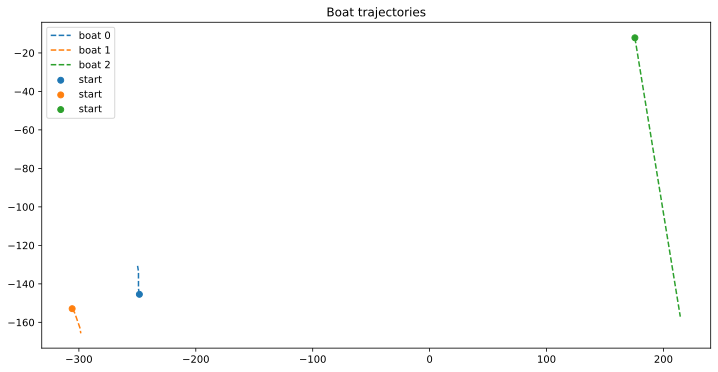

In [17]:
fig = plt.subplots(1, 1, figsize=(12, 6))
plt.title("Boat trajectories")

for i, df in enumerate(m):
    plt.scatter(list(df[f"b{i}_x"])[0], list(df[f"b{i}_y"])[0], label="start")
    plt.plot(list(df[f"b{i}_x"]), list(df[f"b{i}_y"]), '--', label=f"boat {i}")

plt.legend()
plt.show()